## Physics-Informed Neural Networks for 1D Burgers Equation

### Introduction

Physics-Informed Neural Networks (PINNs), introduced by *Raissi et al. (2019)*, represent a transformative approach that seamlessly integrates physical laws into the training of neural networks. Unlike traditional neural networks that rely solely on data-driven methodologies, PINNs leverage the underlying governing equations (such as partial differential equations) directly within the loss function of the network.

The central idea behind PINNs is to encode known physical constraints into the neural network's optimization process (basically the loss function), enabling the network not only to fit observational data but also to adhere closely to the underlying physics of the problem. This approach results in neural networks that are inherently consistent with physical laws, making PINNs highly effective in scenarios where data might be sparse or noisy.

PINNs have found applications across various scientific and engineering domains, including fluid dynamics, solid mechanics, quantum mechanics, and more. Their primary advantage is the ability to yield physically accurate predictions with fewer or (no observed) training data points and improved interpretability.

In general, PINNs are unsupervised, but they can be augmented with available data. However, employing PINNs also introduces specific challenges, such as ensuring adequate convergence during training, balancing the contribution of data-fitting (if data is present) and physics-based losses, and managing the computational complexity associated with evaluating the governing equations.

In [41]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pathlib import Path
from pyDOE import lhs
import torch.optim as optim     #optimizer
import time

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Ensure deterministic behavior on GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
NVIDIA RTX A6000


### Problem Setup

We consider the Burgers equation in one-dimension, which is a quasi-linear parabolic partial differential equation given as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \qquad 0 < x < 1, t > 0,
\end{equation}
with initial condition
$$
    u(x,0) = sin(\pi x), \qquad 0< x < 1,
$$
and (homogenous) boundary conditions  
$$
    u(0,t) =  u(1,t) = 0,  \qquad t > 0.
$$

> Note: The exact solution of the above Burger's equation can be obtained using the Hopf-Cole transformation, that transforms the equation into a linear heat equation.

To solve using PINNs, define a residual $f(t, x)$ as:
\begin{equation}
f := \frac{\partial u_{\theta}}{\partial t} + u_{\theta} \frac{\partial u_{\theta}}{\partial x} - \nu \frac{\partial^2 u_{\theta}}{\partial x^2},
\end{equation}
where $ u_{\theta}(x, t)$ is the velocity in the Burgers equation, now represented as a neural network (i.e is the output of a neural network).

**Our goal is to let $f \approx 0 $, so that our neural network output $u_{\theta}$ will satisfy the Burgers equation (thus, a solution!!).**

What makes a PINN different from a vanilla neural network is basically the loss function. In a PINN, the neural network parameters are trained by minimizing a composite loss function:
$$
MSE = MSE_u + MSE_f,
$$
where
$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}\left| u_{\theta}(t_u^i, x_u^i) - u^i \right|^2,
$$
and,
$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}\left| f(t_f^i, x_f^i) \right|^2.
$$

In this formulation:

* $ (t_u^i, x_u^i, u^i)$ are observed data points with known values of the solution $ u $, such as the boundary points and/or data from a dataset (or exeperiments).

* $ (t_f^i, x_f^i)$ are collocation points used to enforce the differential equation residual $ f(t,x) \approx 0 $.

> How do we compute the derivatives required for evaluating $ f(t,x) $? They are computed using automatic differentiation (or some known numerical differencing techniques, though this is less common), enabling the simultaneous enforcement of data-fitting and physical constraints.

> In this Notebook, we take $\nu = 1.0$

### Configuration and Data Generation

In [42]:
class config:
  def __init__(self):
    #The training parameters
    self.nu = 1.0
    self.x0 = 0  #x0 :Left boundary point
    self.xf = 1  #xf (x final): Right boundary point
    self.layers = [2,125, 256, 125, 1]
    self.spatial_resolution =  300
    self.temporal_resolution = 150

    #Defining the initial condition
    self.init_cond = lambda x: torch.sin(torch.pi * x) 
    self.col_pts = 10000 #Number of collocation points (points in the domain to train on)
    self.num_epoch = 20000


    #Optimizer
    self.lr = 1e-3

    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers1d_pinn'


cfg = config()

In [43]:
#Automatic differentiation
def dfx(f, x):
    gouts = torch.ones_like(f)  # To ensure it matches shape of output f
    return grad([f], [x], grad_outputs=gouts, create_graph=True)[0]

In [44]:
def prepare_data(cfg):
    x = torch.linspace(cfg.x0,cfg.xf, cfg.spatial_resolution).view(-1,1).float()
    t = torch.linspace(0,1, cfg.temporal_resolution).view(-1,1).float()

    #We can create a meshgrid of all possible points for our test data
    X,T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij')
    #Next we flatten this meshgrid and concatenate into a set of all possible coordinate points needed as the input of the PINN
    x_test = torch.cat((X.reshape(-1,1), T.reshape(-1,1)), dim = 1)
    print(f"The shape of the testing data is: {x_test.shape}")

    #Now, we will create th training dataset.
    #We will be training on random points inside the domain Omega = (0,1) x (0,1), and on the boundary and initial points
    #The points inside the domain will be generated randomly using Latin Hypercube Sampling
    lower_bound = x_test[0]; upper_bound = x_test[-1]
    print(f"The boundary points are: {lower_bound} and {upper_bound}")

    x_inner = lower_bound + (upper_bound - lower_bound)*torch.tensor(lhs(2,cfg.col_pts)).float()
    cfg.x_inner = x_inner
    print(f"Shape of training points inside the domain: {x_inner.shape} ")

    #Next we have to generate the boundary and initial coordinate points, and their corresponding solution u
    #1) The initial condition u(x,0) = sin(pi * x)
    x_initial = torch.cat((x,torch.zeros_like(x)), dim = 1) #All possible initial points at time t = 0
    u_init = cfg.init_cond(x)

    #2) The left boundary condition u(0,t) = 0
    x_bound_left = torch.cat((torch.zeros_like(t), t), dim = 1)
    u_bound_left = torch.zeros_like(t)


    #3) The right boundary condition u(1,t) = 0
    x_bound_right = torch.cat((torch.ones_like(t), t), dim = 1)
    u_bound_right = torch.zeros_like(t)

    #We need to stack all these boundary and initial points vertically, so that we can randomly pick some for training
    x_bound = torch.cat((x_initial, x_bound_left, x_bound_right), dim = 0)
    u_bound = torch.cat((u_init, u_bound_left, u_bound_right), dim = 0)
    print(f"Shape of total boundary points: {x_bound.shape}")

    #Choosing randomly,
    Nu = cfg.spatial_resolution + cfg.temporal_resolution
    idx=np.random.choice(x_bound.shape[0],Nu,replace=False)
    cfg.x_bound_random=x_bound[idx,:].to(device)
    cfg.u_bound_random =u_bound[idx,:].to(device)
    print(f"Shape of boundary points for training: {x_bound[idx,:].shape}")

    #Since the boundary points need to also satisfy the PDE, we can combine it to make a complete training data. Though, it is not compulsory
    x_train = torch.cat((x_bound[idx,:], x_inner), dim = 0)
    print(f"Final shape of training data: {x_train.shape} ")

    #Finally, we create the dataloader

    return x_train, x_test

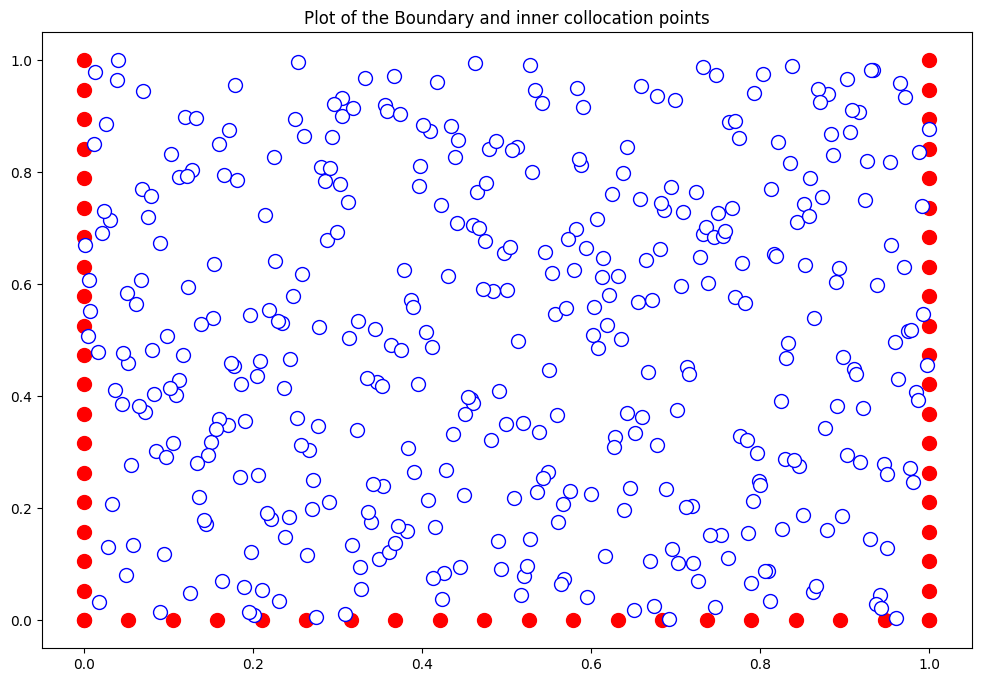

In [45]:
#We can visualize the data to understand them clearly
def for_visuals(cfg):
    x = torch.linspace(cfg.x0,cfg.xf, 20).view(-1,1)
    t = torch.linspace(0,1, 20).view(-1,1)
    lower_bound = torch.tensor([0.,0.]); upper_bound = torch.tensor([1.,1.])
    x_inner = lower_bound + (upper_bound - lower_bound)*torch.tensor(lhs(2,400)).float()
    x_bound_left = torch.cat((torch.zeros_like(t), t), dim = 1)
    x_bound_right = torch.cat((torch.ones_like(t), t), dim = 1)
    x_initial = torch.cat((x,torch.zeros_like(x)), dim = 1)
    x_bound = torch.cat((x_initial, x_bound_left, x_bound_right), dim = 0)
    plt.figure(figsize = (12,8))
    plt.title("Plot of the Boundary and inner collocation points")
    plt.scatter(x_bound[:,0], x_bound[:,1],  marker='o', s=100, c='r')
    plt.scatter(x_inner[:,0], x_inner[:,1],  marker='o', s=100,color = 'white', edgecolors = 'blue')
    plt.show()
for_visuals(cfg)

### The PINN Training

In [46]:
#first we define our NN module
class PINN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.Tanh()
        self.layers = cfg.layers #The number of layers

        #Defining the linear layers
        self.linears = self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])

    def forward(self,x):
        a = x.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [47]:
#Defining the necessary functions needed for training
def PDEloss(NN,cfg,x):
    g = x.clone().to(device)
    g.requires_grad = True #For Automatic differentiation
    u_hat = NN(g) #The forward pass
    d_u_hat = dfx(u_hat,g); d2_u_hat = dfx(d_u_hat, g)
    u_hat_t = d_u_hat[:,[1]]; u_hat_x = d_u_hat[:,[0]]; u_hat_xx = d2_u_hat[:,[0]] #0 for x, 1 for t
    res = u_hat_t + u_hat*u_hat_x - cfg.nu * u_hat_xx #The Burgers equation
    Loss = nn.MSELoss()
    loss = Loss(res.float(), torch.zeros_like(res).float())
    return loss

def boundary_loss(NN,x,u):
    u_hat = NN(x)
    assert u_hat.shape == u.shape, f"Shape Mismatch! prediction shape:{u_hat.shape}, target shape: {u.shape}"
    Loss = nn.MSELoss()
    loss = Loss(u.float(),u_hat.float())
    return loss

#### Learning Rate Finder

This allows us to find the best learning rate for our problem.

In [52]:
model_lr = PINN(cfg)
model_lr.to(device)
print(model_lr)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

PINN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=125, bias=True)
    (1): Linear(in_features=125, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=125, bias=True)
    (3): Linear(in_features=125, out_features=1, bias=True)
  )
)


The shape of the testing data is: torch.Size([45000, 2])
The boundary points are: tensor([0., 0.]) and tensor([1., 1.])
Shape of training points inside the domain: torch.Size([10000, 2]) 
Shape of total boundary points: torch.Size([600, 2])
Shape of boundary points for training: torch.Size([450, 2])
Final shape of training data: torch.Size([10450, 2]) 


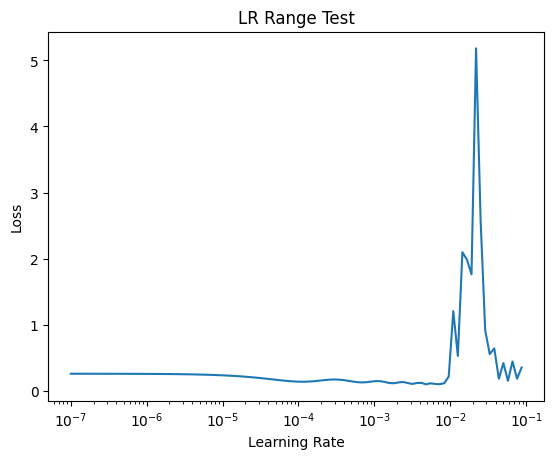

In [53]:
#Setting up the variables
x_train, x_test = prepare_data(cfg)
x_train.to(device); x_test.to(device)
losses = []
lrs = []

#Training for different learning rates between [1e-7,0.1]
start_lr = 1e-7
end_lr = 0.1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

#Initial learning rate
lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss = PDEloss(model_lr,cfg,x_train)
    bound_loss = boundary_loss(model_lr,cfg.x_bound_random,cfg.u_bound_random)
    loss = pde_loss + bound_loss 
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

Points to note from the plot:
* The loss gradually decreases from $10^{-7}$ to around $10^{-3}$
* Then, the minimum loss appears around $10^{-3}$, but explodes and unstable around $10^{-2}$ and above. This is a sign that the learning rate is too high.
* Hence, we will choose our learning to be $10^{-3}$ or something very close to it.

> **It is important to note that the plot can change between runs but in general will look similar. You can run it severally for an optimized selection of the learning rate**

#### Training

In [28]:
model = PINN(cfg)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

PINN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=125, bias=True)
    (1): Linear(in_features=125, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=125, bias=True)
    (3): Linear(in_features=125, out_features=1, bias=True)
  )
)


In [54]:
def pinn_trainer(NN,cfg):
    metrics = {'total_loss':[], 'pde_loss':[], 'bound_loss':[]}
    x_train, x_test = prepare_data(cfg) #Obtaining the train and test data
    x_train.to(device); x_test.to(device)

    stime = time.time()
    for iter in range(cfg.num_epoch + 1):
        optimizer.zero_grad()
        #The PDE Loss
        pde_loss = PDEloss(NN,cfg,x_train)
        metrics['pde_loss'].append(pde_loss.item())

        #The loss at the boundary
        bound_loss = boundary_loss(NN,cfg.x_bound_random,cfg.u_bound_random)
        metrics['bound_loss'].append(bound_loss.item())

        #Total loss
        loss = pde_loss + bound_loss
        metrics['total_loss'].append(loss.item())

        if iter % (cfg.num_epoch // 10) == 0:
            print(f"Epoch: {iter} --- loss: {loss.item()}")
        loss.backward()

        optimizer.step()
        ftime = time.time()
    ttime = (ftime - stime)/60
    print(f'Total training time is {ttime} minutes')
    return NN, metrics


In [55]:
pinn_burgers1d, metrics = pinn_trainer(model,cfg)

The shape of the testing data is: torch.Size([45000, 2])
The boundary points are: tensor([0., 0.]) and tensor([1., 1.])
Shape of training points inside the domain: torch.Size([10000, 2]) 
Shape of total boundary points: torch.Size([600, 2])
Shape of boundary points for training: torch.Size([450, 2])
Final shape of training data: torch.Size([10450, 2]) 
Epoch: 0 --- loss: 0.30300435423851013
Epoch: 2000 --- loss: 0.0007310507353395224
Epoch: 4000 --- loss: 0.00014779016782995313
Epoch: 6000 --- loss: 0.00012047353811794892
Epoch: 8000 --- loss: 0.0005372586310841143
Epoch: 10000 --- loss: 0.000450761872343719
Epoch: 12000 --- loss: 0.0002444529382046312
Epoch: 14000 --- loss: 0.0004048369883093983
Epoch: 16000 --- loss: 6.936449790373445e-05
Epoch: 18000 --- loss: 7.002129859756678e-05
Epoch: 20000 --- loss: 0.0010032232385128736
Total training time is 2.7277788559595746 minutes


### Evaluation

In [60]:
predictions = pinn_burgers1d(x_test.to(device)).cpu()

In [ ]:
u_pinns = predictions.reshape(cfg.temporal_resolution, cfg.spatial_resolution).transpose(1,0)

torch.Size([300, 150])

C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_50280\2355595305.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = torch.abs(u_init - u_pinns[:,0].detach().numpy())


<Figure size 1200x800 with 0 Axes>

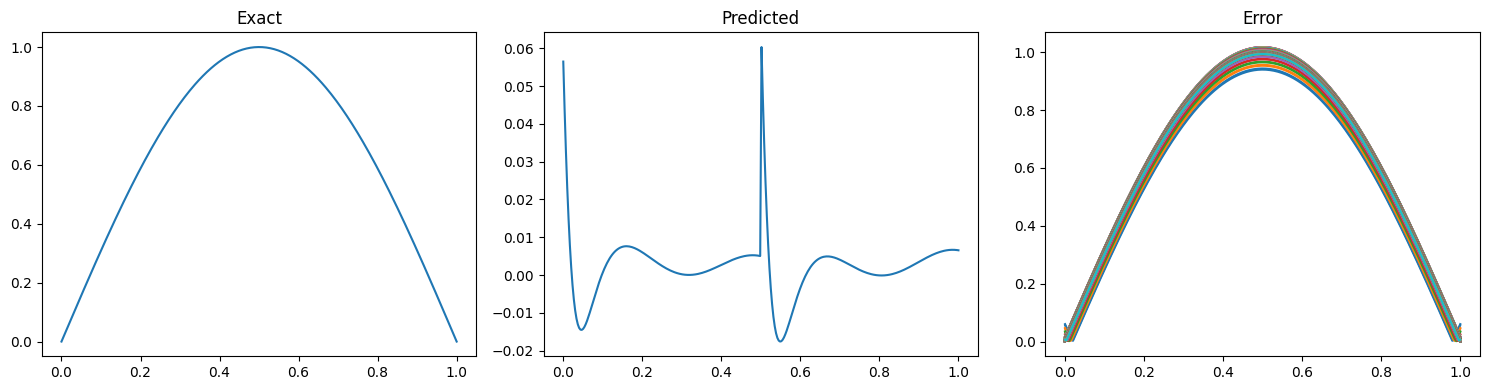

In [67]:
#First we plot the prediction of the initial solution and the exact initial solution
x = torch.linspace(cfg.x0,cfg.xf, cfg.spatial_resolution).view(-1,1).float()
t = torch.linspace(0,1, cfg.temporal_resolution).view(-1,1).float()
u_init = cfg.init_cond(x)
plt.figure(figsize=(12, 8))
plt.suptitle("Predicted vs. Reference Initial solution", fontsize=16)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot each function in its own subplot
ax1.plot(x, u_init)
ax1.set_title("Exact")

ax2.plot(x, u_pinns[:,0].detach().numpy())
ax2.set_title("Predicted")

diff = torch.abs(u_init - u_pinns[:,0].detach().numpy())
ax3.plot(x, diff)
ax3.set_title("Error")

plt.tight_layout()
plt.show()

In [72]:
%matplotlib qt
# Plot setup
fig, ax = plt.subplots()
line, = ax.plot(x, u_pinns[:, 0].detach().numpy())
ax.set_ylim(-0.1, 1.1)

for i in range(cfg.temporal_resolution):
    line.set_ydata(u_pinns[:, i].detach().numpy())
    ax.set_title(f"Time step {i}")
    plt.pause(0.05)

plt.show()
